### Some imports

In [22]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from keras.datasets import mnist

warnings.filterwarnings('ignore')

### An existing k-means algorithm with three different distance metrics

In [23]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances

class KMeansWithCustomDistance(KMeans):
    def __init__(self, n_clusters, init, distance='euclidean', **kwargs):
        super().__init__(n_clusters=n_clusters, init=init, **kwargs)
        self.distance = distance

    def _pairwise_distances_argmin(self, X):
        if self.distance == 'euclidean':
            return np.argmin(euclidean_distances(X, self.cluster_centers_), axis=1)
        elif self.distance == 'manhattan':
            return np.argmin(manhattan_distances(X, self.cluster_centers_), axis=1)
        elif self.distance == 'cosine':
            return np.argmin(1 - cosine_distances(X, self.cluster_centers_), axis=1)
        else:
            raise ValueError(f"Invalid distance metric: {self.distance}")

### Get MNIST data

In [24]:
(X_train, y_train), (X_test, y_test) = mnist.load_data() # load_data() function takes 60000 for training and 10000 for test. 
X_train = X_train.astype('float32') / 255.0 # normalize
X_train = X_train.reshape(60000, 28*28) # to dimension reducing with 784=28*28

# According to HW4, we need 56000 data, because get %80 training data, %20 test data, so 70.000 * 0.8 = 56.000, 
X_train = X_train[:1000] # for now 1000
y_train = y_train[:1000]
kmeans = KMeansWithCustomDistance(n_clusters=10, init='k-means++', distance='manhattan')

### Get clusters

In [25]:
kmeans.fit(X_train)
labels_manhattan = kmeans.predict(X_train)
print("Cluster labels (Manhattan):", labels_manhattan)

centers_manhattan = kmeans.cluster_centers_
print("Cluster centers (Manhattan):", centers_manhattan)

Cluster labels (Manhattan): [7 0 8 1 8 9 2 7 2 5 7 2 4 3 2 5 9 7 2 2 8 0 5 1 2 4 8 4 5 1 2 7 3 5 0 2 3
 0 8 3 2 7 2 2 2 5 4 7 2 7 4 6 8 2 5 7 6 5 8 1 8 1 3 0 8 2 3 1 6 4 2 5 2 3
 4 0 4 1 1 5 4 0 9 3 8 7 2 5 6 5 3 5 8 3 7 0 5 7 4 1 2 5 2 5 2 1 3 7 6 2 8
 4 2 1 6 5 8 4 6 0 4 6 1 5 2 7 3 5 2 3 4 5 2 2 8 7 4 1 4 5 2 1 8 8 4 2 7 3
 5 4 2 3 2 5 8 3 6 7 8 9 2 7 8 1 8 3 5 5 1 0 8 9 8 2 2 2 8 1 0 4 2 5 4 5 2
 5 2 9 4 2 2 2 0 5 8 5 8 7 4 9 2 1 7 7 3 1 6 5 2 6 4 2 2 9 8 7 4 8 3 7 9 3
 8 5 7 7 8 5 8 6 5 2 8 9 4 7 7 8 3 2 2 8 4 5 4 7 6 5 2 6 8 2 2 9 4 7 1 8 5
 2 2 3 2 5 8 7 4 8 2 1 2 8 8 2 2 8 2 9 3 7 5 7 8 6 4 2 3 2 8 8 1 7 2 6 8 7
 6 8 4 3 1 5 3 0 8 5 6 5 9 1 2 3 4 5 8 1 4 9 1 5 4 7 8 3 8 9 0 7 4 8 4 3 4
 4 8 2 8 5 8 9 8 7 2 7 8 1 7 9 7 5 8 1 4 5 8 1 4 1 2 6 2 7 8 5 8 9 2 3 2 8
 2 5 8 5 8 9 4 5 9 5 8 9 2 5 8 9 4 5 2 5 4 9 4 7 2 3 4 1 2 0 3 3 8 2 4 7 2
 2 2 5 1 5 2 5 3 7 1 2 2 5 7 3 2 5 8 7 8 0 8 6 3 3 9 7 8 6 8 2 8 7 6 5 8 1
 2 7 8 1 9 3 2 0 4 0 2 1 2 9 6 8 8 8 6 2 6 3 1 5 8 7 2 5 2 0 4 1 8 9 2 4

### If you see the diagram, you will uncommit

In [26]:
# pca = PCA(n_components=2)
# X_train_pca = pca.fit_transform(X_train)
# 
# kmeans.fit(X_train_pca)
# labels_manhattan_pca = kmeans.predict(X_train_pca)
# 
# centers_pca_manhattan = kmeans.cluster_centers_
# print(centers_pca_manhattan)
# 
# plt.figure(figsize=(8, 6))
# plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=labels_manhattan_pca, cmap='viridis')
# plt.scatter(centers_pca_manhattan[:, 0], centers_pca_manhattan[:, 1], c='red', s=100, alpha=0.5)
# plt.title('Cluster Centers and Data Points (PCA)')
# plt.show()

## P.S.
But these are not real label of each image, since the output of the kmeans.labels_ is just group id for clustering. For example, 6 in kmeans.labels_ has similar features with another 6 in kmeans.labels_. There is no more meaning from the label.

To match it with real label, we can tackle the follow things:

- Combine each images in the same group
- Check Frequency distribution of actual labels (using np.bincount)
- Find the Maximum frequent label (through np.argmax), and set the label.

In [27]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    # Loop through the clusters
    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [28]:
kmeans.fit(X_train)
cluster_labels = infer_cluster_labels(kmeans, y_train)
X_clusters_labels = kmeans.predict(X_train)
predicted_labels_with_argmax = infer_data_labels(X_clusters_labels, cluster_labels)

print(predicted_labels_with_argmax[:20])
print(y_train[:20])

[3 0 4 1 4 2 1 3 1 7 3 1 3 6 1 7 4 8 1 1]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


### If you see Kmeans performance for different cluster, you will uncommit

In [29]:
# from sklearn.metrics import accuracy_score
# 
# clusters = [10, 16, 36, 64, 144, 256]
# acc_list = []
# 
# for n_clusters in clusters:
#     estimator = KMeansWithCustomDistance(n_clusters=n_clusters, init='k-means++', distance='manhattan')
#     estimator.fit(X_train)
# 
#     # Determine predicted labels
#     cluster_labels = infer_cluster_labels(estimator, y_train)
#     prediction = infer_data_labels(estimator.labels_, cluster_labels)
#     
#     acc = accuracy_score(y_train, prediction)
#     acc_list.append(acc)
#     print('Accuracy: {}\n'.format(acc))

In [30]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy_scores = []
confusion_matrices = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation this function gives me an index subset of X_train
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    kmeans.fit(X_train_fold)
    
    cluster_labels_fold = infer_cluster_labels(kmeans, y_train_fold)
    X_cluster_labels_fold = kmeans.predict(X_val_fold)
    predicted_labels_fold = infer_data_labels(X_cluster_labels_fold, cluster_labels_fold)

    accuracy = accuracy_score(y_val_fold, predicted_labels_fold)
    cm = confusion_matrix(y_val_fold, predicted_labels_fold)

    accuracy_scores.append(accuracy)
    confusion_matrices.append(cm)
    

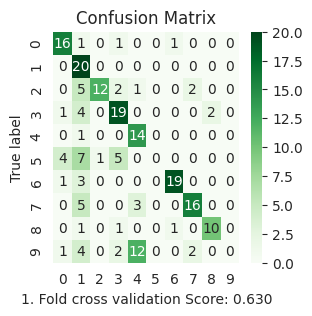

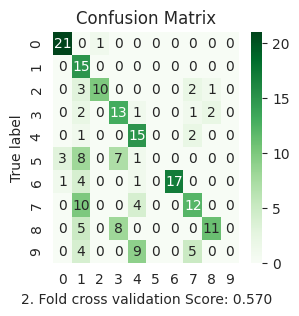

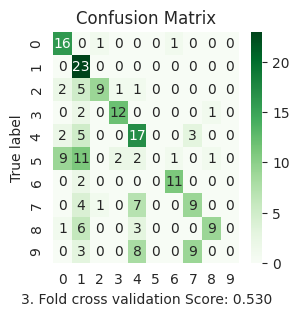

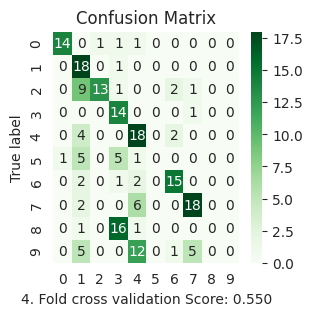

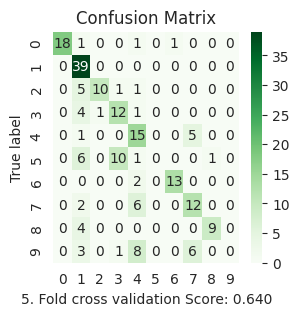

Average accuracy: 0.5840000000000001


In [31]:
import seaborn as sns

for i, score in enumerate(accuracy_scores):
    plt.figure(figsize=(3, 3))
    sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cmap='Greens')
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    i+=1
    plt.xlabel(f'{i}. Fold cross validation Score: {score:.3f}')
    plt.plot()

plt.show()

# Calculate average accuracy across all folds
avg_accuracy = np.mean(accuracy_scores)
print(f"Average accuracy: {avg_accuracy}")

In [32]:
import pandas as pd
import numpy as np

# predicted_labels and y_train are the output of kmeans algorithm
predicted_labels = predicted_labels_with_argmax
y_train = y_train

# Create a contingency table
contingency_table = pd.crosstab(predicted_labels, y_train)

# Initialize a dictionary to store the cluster labels
cluster_labels = {}

# Initialize a set to keep track of assigned labels
assigned_labels = set()

# Iterate over the contingency table to label the clusters
while len(cluster_labels) < contingency_table.shape[0]:
    max_val = contingency_table.values.max()
    cluster_idx, label_idx = np.unravel_index(contingency_table.values.argmax(), contingency_table.shape)
    label = contingency_table.columns[label_idx]
    if label not in assigned_labels:
        cluster_labels[cluster_idx] = label
        assigned_labels.add(label)
    contingency_table.values[cluster_idx, label_idx] = 0  # reset the max value to 0

# Print the cluster labels
print(cluster_labels)

{1: 1, 0: 0, 5: 6, 3: 3, 6: 7, 7: 8, 4: 4, 2: 2}
